In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download vijaykumar1799/face-mask-detection #download dataset

 92% 205M/222M [00:01<00:00, 130MB/s]
100% 222M/222M [00:01<00:00, 146MB/s]


In [7]:
! unzip face-mask-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/with_mask/1890.png  
  inflating: Dataset/with_mask/1891.png  
  inflating: Dataset/with_mask/1892.png  
  inflating: Dataset/with_mask/1893.png  
  inflating: Dataset/with_mask/1894.png  
  inflating: Dataset/with_mask/1895.png  
  inflating: Dataset/with_mask/1896.png  
  inflating: Dataset/with_mask/1897.png  
  inflating: Dataset/with_mask/1898.png  
  inflating: Dataset/with_mask/1899.png  
  inflating: Dataset/with_mask/19.png  
  inflating: Dataset/with_mask/190.png  
  inflating: Dataset/with_mask/1900.png  
  inflating: Dataset/with_mask/1901.png  
  inflating: Dataset/with_mask/1902.png  
  inflating: Dataset/with_mask/1903.png  
  inflating: Dataset/with_mask/1904.png  
  inflating: Dataset/with_mask/1905.png  
  inflating: Dataset/with_mask/1906.png  
  inflating: Dataset/with_mask/1907.png  
  inflating: Dataset/with_mask/1908.png  
  inflating: Dataset/with_mask/1909.png  
  inflating: Dataset/with_ma

In [40]:
#import lib
# Disable warning
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [14]:
Data_Path = Path("/content/Dataset")

In [15]:
PNG_Path = list(Data_Path.glob(r"*/*.png"))

In [16]:
# For Label
PNG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],PNG_Path))

In [17]:
PNG_Path_Series = pd.Series(PNG_Path,name="PNG").astype(str)
PNG_Labels_Series = pd.Series(PNG_Labels,name="CATEGORY")

In [19]:
#Transform to Main Dataframe
Main_Data = pd.concat([PNG_Path_Series,PNG_Labels_Series],axis=1)

In [20]:
#check
print(Main_Data.head(-1))

                                         PNG      CATEGORY
0      /content/Dataset/without_mask/861.png  without_mask
1     /content/Dataset/without_mask/2132.png  without_mask
2      /content/Dataset/without_mask/231.png  without_mask
3     /content/Dataset/without_mask/2941.png  without_mask
4      /content/Dataset/without_mask/642.png  without_mask
...                                      ...           ...
8976     /content/Dataset/with_mask/1846.png     with_mask
8977     /content/Dataset/with_mask/1700.png     with_mask
8978     /content/Dataset/with_mask/2398.png     with_mask
8979     /content/Dataset/with_mask/1224.png     with_mask
8980     /content/Dataset/with_mask/1847.png     with_mask

[8981 rows x 2 columns]


In [21]:
Main_Data["CATEGORY"].value_counts()

without_mask             2994
mask_weared_incorrect    2994
with_mask                2994
Name: CATEGORY, dtype: int64

In [22]:
#shuffle data
Main_Data = Main_Data.sample(frac=1).reset_index(drop=True)

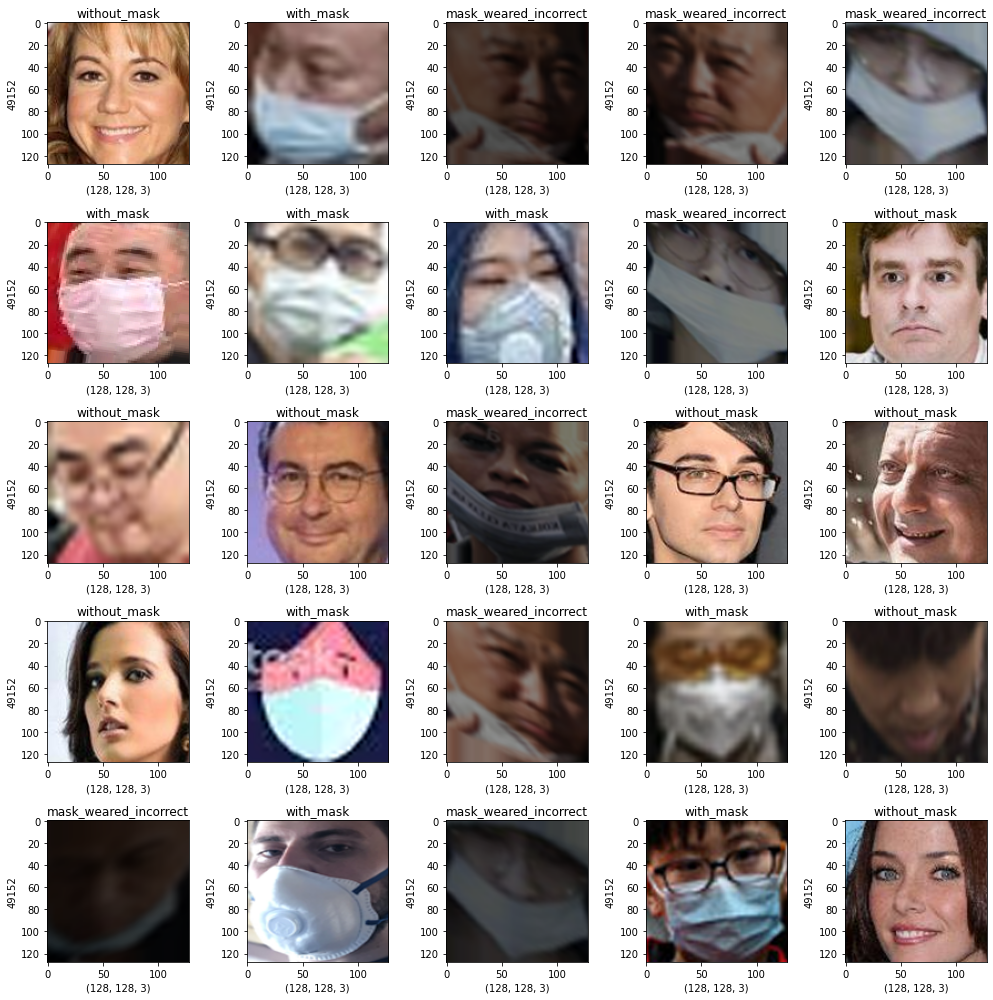

In [25]:
# Image Example Viz
import cv2
figure,axis = plt.subplots(nrows=5,ncols=5,figsize=(14,14))

for indexing,run_axes in enumerate(axis.flat):
    Reading_IMG = cv2.imread(Main_Data["PNG"][indexing])
    Transformation_IMG = cv2.cvtColor(Reading_IMG,cv2.COLOR_BGR2RGB)
    
    run_axes.set_xlabel(Transformation_IMG.shape)
    run_axes.set_ylabel(Transformation_IMG.size)
    run_axes.set_title(Main_Data["CATEGORY"][indexing])
    
    run_axes.imshow(Transformation_IMG)
    
plt.tight_layout()
plt.show()

In [26]:
#Splitting data
Train_Data,Test_Data = train_test_split(Main_Data,train_size=0.8,shuffle=True,random_state=42)

In [27]:
print(Train_Data.shape)

(7185, 2)


In [28]:
print(Test_Data.shape)

(1797, 2)


In [29]:
Train_IMG_Generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=25,
                                        shear_range=0.5,
                                        zoom_range=0.5,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode="nearest",
                                        validation_split=0.2)

In [30]:
Test_IMG_Generator = ImageDataGenerator(rescale=1./255)

In [31]:
Train_IMG_Set = Train_IMG_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                       x_col="PNG",
                                                       y_col="CATEGORY",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128), # can be changed,
                                                       subset="training")

Found 5748 validated image filenames belonging to 3 classes.


In [32]:
Validation_IMG_Set = Train_IMG_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                       x_col="PNG",
                                                       y_col="CATEGORY",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128), #conditional,
                                                       subset="validation")

Found 1437 validated image filenames belonging to 3 classes.


In [33]:
Test_IMG_Set = Test_IMG_Generator.flow_from_dataframe(dataframe=Test_Data,
                                                       x_col="PNG",
                                                       y_col="CATEGORY",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128),
                                                       shuffle=False)

Found 1797 validated image filenames belonging to 3 classes.


In [38]:
## Trying to Create Model (Work in Progress)
Model = Sequential()

#
Model.add(Conv2D(32,(3,3),activation="relu",input_shape=(128,128,3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2,2)))

#
Model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2)))

Model.add(Conv2D(128,(3,3),padding="same",activation="relu"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2)))

Model.add(Conv2D(128,(3,3),padding="same",activation="relu"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2)))

#
Model.add(Flatten())
Model.add(Dense(256,activation="relu"))
Model.add(Dropout(0.5))

#
Model.add(Dense(3,activation="softmax"))

In [41]:
Early_Stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [42]:
Model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [43]:
print(Model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0

In [44]:
cnn_model = Model.fit(Train_IMG_Set,validation_data=Validation_IMG_Set,callbacks=Early_Stop,epochs=50)

Epoch 1/50
180/180 [==============================] - 348s 2s/step - loss: 0.6564 - accuracy: 0.7516 - val_loss: 0.9607 - val_accuracy: 0.6590
Epoch 2/50
180/180 [==============================] - 335s 2s/step - loss: 0.4668 - accuracy: 0.8225 - val_loss: 0.8381 - val_accuracy: 0.6820
Epoch 3/50
180/180 [==============================] - 334s 2s/step - loss: 0.4285 - accuracy: 0.8373 - val_loss: 0.7126 - val_accuracy: 0.7439
Epoch 4/50
180/180 [==============================] - 333s 2s/step - loss: 0.3868 - accuracy: 0.8537 - val_loss: 0.6873 - val_accuracy: 0.6437
Epoch 5/50
180/180 [==============================] - 339s 2s/step - loss: 0.3563 - accuracy: 0.8742 - val_loss: 0.4551 - val_accuracy: 0.8594
Epoch 6/50
180/180 [==============================] - 338s 2s/step - loss: 0.3156 - accuracy: 0.8920 - val_loss: 0.4284 - val_accuracy: 0.8782
Epoch 7/50
180/180 [==============================] - 337s 2s/step - loss: 0.3034 - accuracy: 0.8914 - val_loss: 0.3145 - val_accuracy: 0.9081

<Figure size 720x720 with 0 Axes>

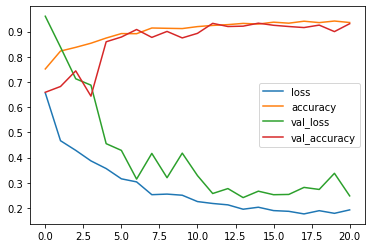

In [45]:
viz_data = pd.DataFrame(cnn_model.history)
figure = plt.figure(figsize=(10,10))

viz_data.plot()

In [46]:
#save
Model.save("cnn_model.h5")
Model.save_weights("cnn_model_weight.h5")

In [47]:
Model_Results = Model.evaluate(Test_IMG_Set)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

57/57 [==============================] - 24s 416ms/step - loss: 0.1544 - accuracy: 0.9694
LOSS:  0.1544
ACCURACY:  0.9694


In [48]:
#testing
Prediction_Number = Model.predict(Test_IMG_Set)

57/57 [==============================] - 22s 384ms/step


> label

0= Mask weared Incorrect


1= With Mask


2= Without mask

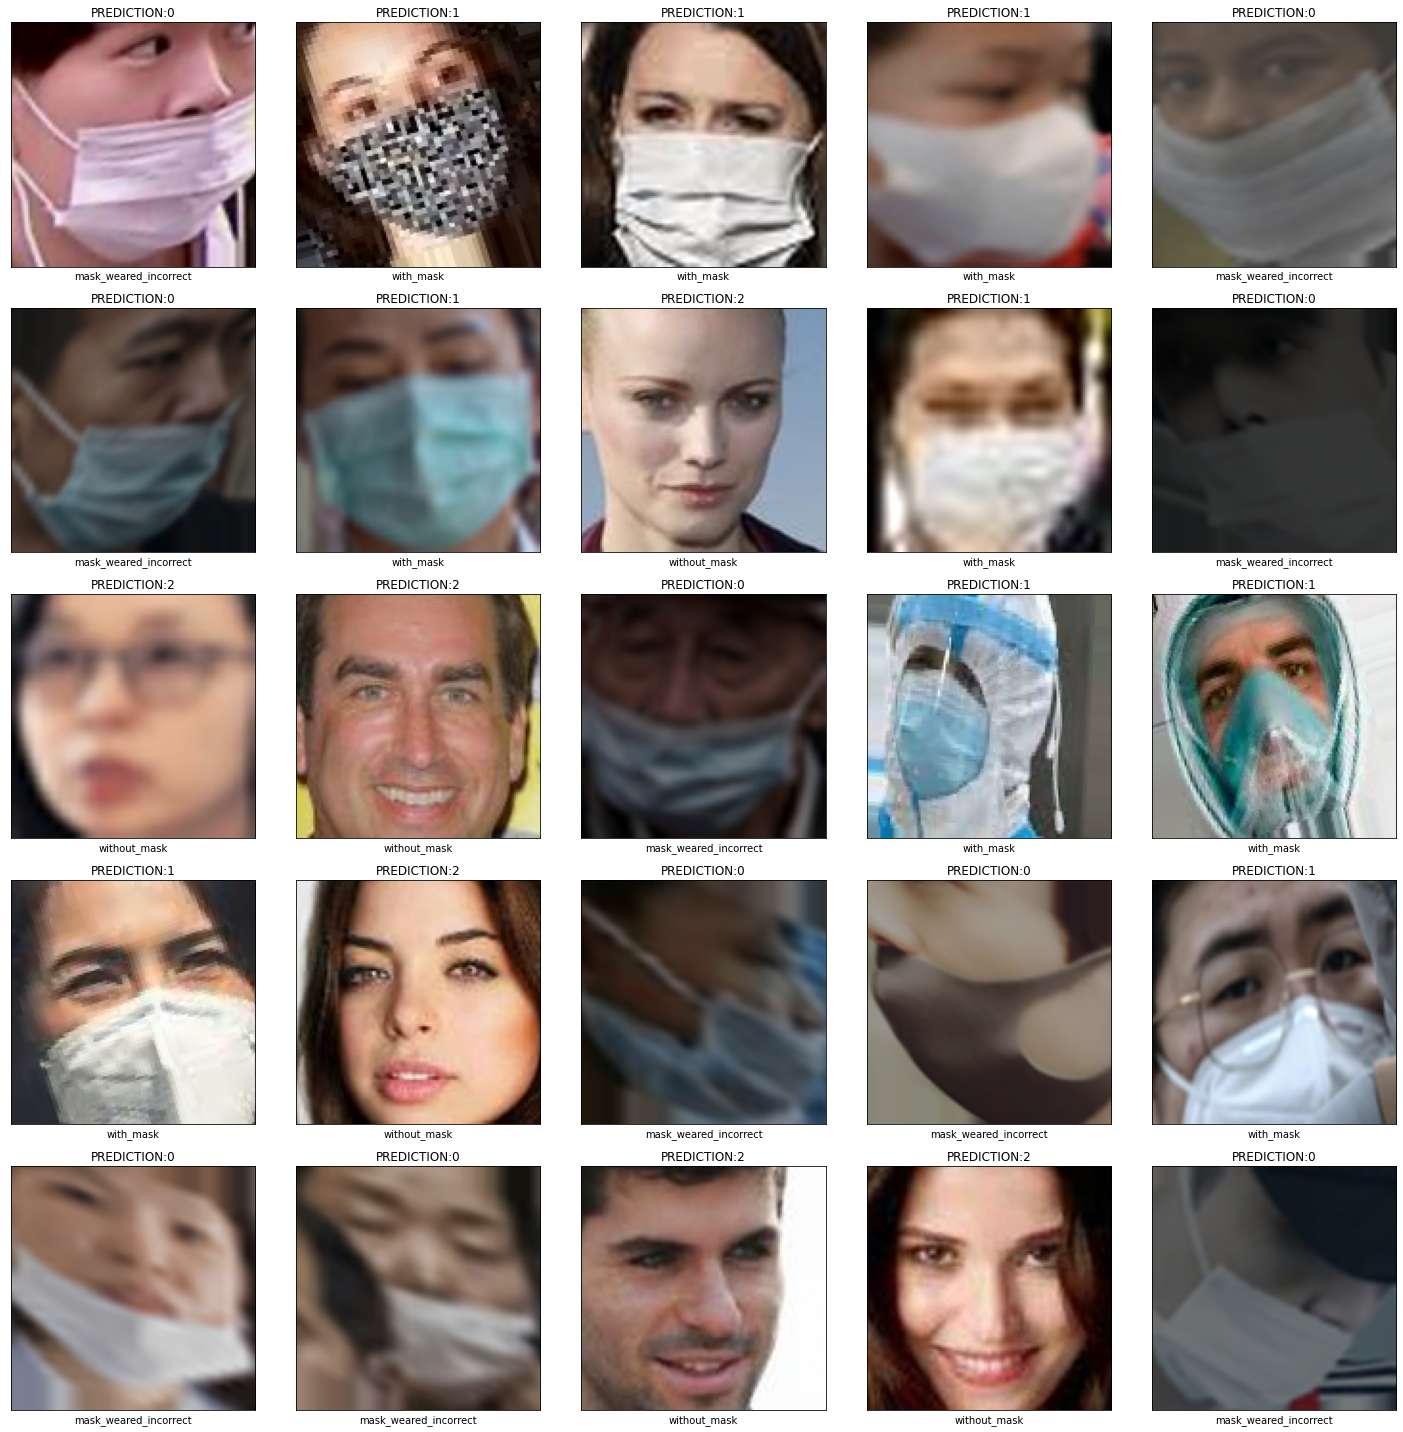

In [49]:
Prediction = Prediction_Number.argmax(axis=-1)
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Test_Data["PNG"].iloc[i]))
    ax.set_title(f"PREDICTION:{Prediction[i]}")
    ax.set_xlabel(Test_Data["CATEGORY"].iloc[i])
plt.tight_layout()
plt.show()